In [3]:
# Importing necessary libraries for data handling, text processing, and building a neural network using PyTorch.
import pandas as pd
import numpy as np
import re
import nltk
import string
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle

# Downloading necessary NLTK data files for tokenization (only needs to be run once).
nltk.download('punkt')

# Checking if GPU is available for training; if not, using CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loading the Shakespeare dataset and combining all lines into a single text for processing.
df = pd.read_csv('Shakespeare_data.csv')
text = ' '.join(df['PlayerLine'].astype(str).tolist())

# Function to preprocess text data by removing punctuation, numbers, extra whitespaces, converting to lowercase, and tokenizing.
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    words = word_tokenize(text)
    return words

# Applying text preprocessing to the combined text.
words = preprocess_text(text)

# Building vocabulary from the preprocessed words, creating mappings of words to integers and vice-versa for the model.
from collections import Counter
word_counts = Counter(words)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab_to_int = {word: idx+1 for idx, word in enumerate(vocab)}  # Indexing starts from 1 to reserve 0 for padding.
int_to_vocab = {idx: word for word, idx in vocab_to_int.items()}

# Converting text into sequences of fixed length (10 words) to create input-output pairs for training the model.
sequences = []
seq_length = 10  # Setting sequence length to 10 for better context in predictions.
for i in range(seq_length, len(words)):
    seq = words[i-seq_length:i+1]
    encoded_seq = [vocab_to_int[word] for word in seq]
    sequences.append(encoded_seq)

# Preparing the input (X) and target output (y) from the encoded sequences.
sequences = np.array(sequences)
X = sequences[:, :-1]
y = sequences[:, -1]

# Splitting the data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Converting training and validation data into PyTorch tensors for model input.
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Creating DataLoader objects for efficient batch processing during training and validation.
batch_size = 256
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Setting model parameters including vocabulary size, embedding dimensions, LSTM hidden size, and dropout rate.
vocab_size = len(vocab_to_int) + 1  # +1 to include a padding index.
embedding_dim = 50  # Dimension of word embeddings.
hidden_dim = 256  # Number of LSTM units in each layer.
num_layers = 2  # Using a two-layer LSTM for better learning capacity.
dropout = 0.2  # Dropout rate to prevent overfitting.

# Defining and initializing layers of the model: embedding layer, LSTM, dropout, and fully connected layer.
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
fc_layer = nn.Linear(hidden_dim, vocab_size)
dropout_layer = nn.Dropout(dropout)

# Moving model layers to the specified device (GPU or CPU).
embedding_layer.to(device)
lstm_layer.to(device)
fc_layer.to(device)
dropout_layer.to(device)

# Setting up loss function (cross-entropy) and optimizer (Adam) for training the model.
criterion = nn.CrossEntropyLoss()
parameters = list(embedding_layer.parameters()) + list(lstm_layer.parameters()) + list(fc_layer.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

# Training loop for the LSTM model, iterating over the specified number of epochs.
num_epochs = 20
for epoch in range(num_epochs):
    embedding_layer.train()
    lstm_layer.train()
    fc_layer.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Forward pass through embedding, LSTM, and fully connected layers.
        embeddings = embedding_layer(inputs)
        lstm_out, (hn, cn) = lstm_layer(embeddings)
        lstm_out = dropout_layer(lstm_out[:, -1, :])  # Output of the last time step.
        outputs = fc_layer(lstm_out)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluating the model on the validation set to monitor performance.
    embedding_layer.eval()
    lstm_layer.eval()
    fc_layer.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            embeddings = embedding_layer(inputs)
            lstm_out, (hn, cn) = lstm_layer(embeddings)
            lstm_out = dropout_layer(lstm_out[:, -1, :])
            outputs = fc_layer(lstm_out)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    # Printing training and validation loss for each epoch.
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Saving the trained model parameters and necessary mappings for future use.
torch.save({
    'embedding_layer_state_dict': embedding_layer.state_dict(),
    'lstm_layer_state_dict': lstm_layer.state_dict(),
    'fc_layer_state_dict': fc_layer.state_dict(),
    'dropout_layer_state_dict': dropout_layer.state_dict(),
    'vocab_to_int': vocab_to_int,
    'int_to_vocab': int_to_vocab,
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'seq_length': seq_length,
    'vocab_size': vocab_size,
}, 'word_prediction_model.pt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
Epoch [1/20], Train Loss: 6.6672, Val Loss: 6.3647
Epoch [2/20], Train Loss: 6.1814, Val Loss: 6.1672
Epoch [3/20], Train Loss: 5.9424, Val Loss: 6.0815
Epoch [4/20], Train Loss: 5.7586, Val Loss: 6.0540
Epoch [5/20], Train Loss: 5.6079, Val Loss: 6.0719
Epoch [6/20], Train Loss: 5.4778, Val Loss: 6.1012
Epoch [7/20], Train Loss: 5.3626, Val Loss: 6.1495
Epoch [8/20], Train Loss: 5.2563, Val Loss: 6.2023
Epoch [9/20], Train Loss: 5.1616, Val Loss: 6.2601
Epoch [10/20], Train Loss: 5.0741, Val Loss: 6.3127
Epoch [11/20], Train Loss: 4.9948, Val Loss: 6.3704
Epoch [12/20], Train Loss: 4.9228, Val Loss: 6.4202
Epoch [13/20], Train Loss: 4.8555, Val Loss: 6.4766
Epoch [14/20], Train Loss: 4.7940, Val Loss: 6.5339
Epoch [15/20], Train Loss: 4.7400, Val Loss: 6.5819
Epoch [16/20], Train Loss: 4.6878, Val Loss: 6.6228
Epoch [17/20], Train Loss: 4.6402, Val Loss: 6.6631
Epoch [18/20], Train Loss: 4.5957, Val Loss: 6.7101
Epoch [19/20], Train Loss: 4.5561, Val Loss: 6.7504
Ep

Epoch [1/20], Train Loss: 4.4834, Val Loss: 6.8080
Epoch [2/20], Train Loss: 4.4496, Val Loss: 6.8541
Epoch [3/20], Train Loss: 4.4170, Val Loss: 6.8943
Epoch [4/20], Train Loss: 4.3875, Val Loss: 6.9027
Epoch [5/20], Train Loss: 4.3620, Val Loss: 6.9457
Epoch [6/20], Train Loss: 4.3359, Val Loss: 6.9706
Epoch [7/20], Train Loss: 4.3120, Val Loss: 7.0048
Epoch [8/20], Train Loss: 4.2877, Val Loss: 7.0185
Epoch [9/20], Train Loss: 4.2690, Val Loss: 7.0515
Epoch [10/20], Train Loss: 4.2465, Val Loss: 7.0781
Epoch [11/20], Train Loss: 4.2271, Val Loss: 7.0948
Epoch [12/20], Train Loss: 4.2087, Val Loss: 7.1265
Epoch [13/20], Train Loss: 4.1903, Val Loss: 7.1445
Epoch [14/20], Train Loss: 4.1745, Val Loss: 7.1623
Epoch [15/20], Train Loss: 4.1546, Val Loss: 7.1861
Epoch [16/20], Train Loss: 4.1405, Val Loss: 7.2104
Epoch [17/20], Train Loss: 4.1271, Val Loss: 7.2259
Epoch [18/20], Train Loss: 4.1110, Val Loss: 7.2561
Epoch [19/20], Train Loss: 4.0979, Val Loss: 7.2668
Epoch [20/20], Train 

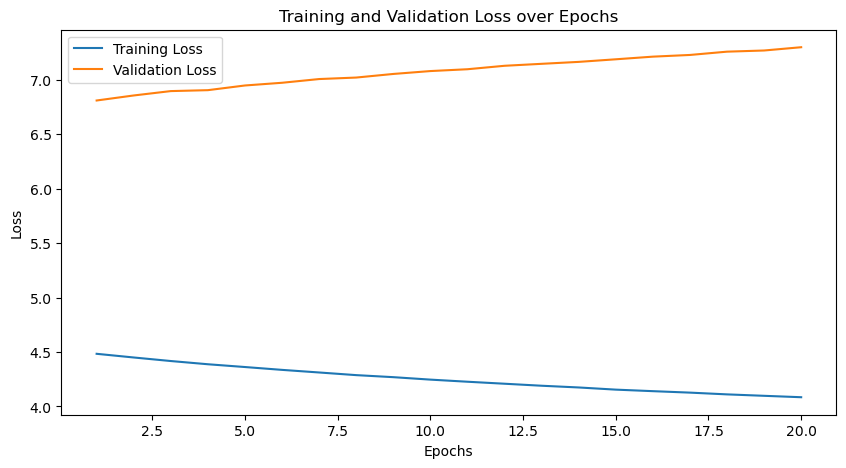

In [8]:
# Importing the necessary library for data visualization.
import matplotlib.pyplot as plt

# Initializing lists to store training and validation loss values for each epoch.
train_losses = []
val_losses = []

# Modifying the training loop to capture loss values for plotting.
# During each epoch, the code performs a forward and backward pass through the model layers,
# computes the training loss, updates the model weights, and stores the average loss per epoch.
# In the validation phase, the model's performance is evaluated without gradient updates, and the loss is recorded.
# The collected loss values are used to visualize the training and validation trends over epochs.

for epoch in range(num_epochs):
    embedding_layer.train()
    lstm_layer.train()
    fc_layer.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Forward pass through the embedding, LSTM, and fully connected layers.
        embeddings = embedding_layer(inputs)
        lstm_out, (hn, cn) = lstm_layer(embeddings)
        lstm_out = dropout_layer(lstm_out[:, -1, :])  # Taking the output of the last time step.
        outputs = fc_layer(lstm_out)
        loss = criterion(outputs, targets)
        loss.backward()  # Backpropagation.
        optimizer.step()  # Update the model parameters.
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store average training loss for this epoch.

    # Validation phase to evaluate model performance on unseen data.
    embedding_layer.eval()
    lstm_layer.eval()
    fc_layer.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            embeddings = embedding_layer(inputs)
            lstm_out, (hn, cn) = lstm_layer(embeddings)
            lstm_out = dropout_layer(lstm_out[:, -1, :])  # Take last time step's output.
            outputs = fc_layer(lstm_out)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store average validation loss for this epoch.

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# After the training loop, visualize and save the loss values over epochs.
# A line plot is created to display training and validation loss trends, helping to assess overfitting and convergence.
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file.
plt.show()


In [9]:
# Function to count the total number of parameters
def count_parameters(layer):
    return sum(p.numel() for p in layer.parameters() if p.requires_grad)

print("Model Summary:")
print("-------------")
print(f"Embedding Layer: {embedding_layer}")
print(f" - Number of parameters: {count_parameters(embedding_layer)}")

print(f"LSTM Layer: {lstm_layer}")
print(f" - Number of parameters: {count_parameters(lstm_layer)}")

print(f"Dropout Layer: {dropout_layer}")
print(f" - Dropout rate: {dropout_layer.p}")

print(f"Fully Connected Layer: {fc_layer}")
print(f" - Number of parameters: {count_parameters(fc_layer)}")

total_params = (
    count_parameters(embedding_layer)
    + count_parameters(lstm_layer)
    + count_parameters(fc_layer)
)

print(f"\nTotal Trainable Parameters: {total_params}")


Model Summary:
-------------
Embedding Layer: Embedding(27365, 50)
 - Number of parameters: 1368250
LSTM Layer: LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.2)
 - Number of parameters: 841728
Dropout Layer: Dropout(p=0.2, inplace=False)
 - Dropout rate: 0.2
Fully Connected Layer: Linear(in_features=256, out_features=27365, bias=True)
 - Number of parameters: 7032805

Total Trainable Parameters: 9242783
